In [ ]:
#next steps:
#remove just the high end of outliers on med_val
#remove skewness of the data with log transformation

#https://www.kaggle.com/prasadperera/the-boston-housing-dataset
#https://stattrek.com/regression/linear-transformation.aspx

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import lin_reg_tests

# Gather/Load Data

In [22]:
# Read in the Boston housing data.
from sklearn.datasets import load_boston
boston = load_boston()

df = pd.DataFrame(boston.data)
df.columns = boston.feature_names
df['med_val'] = boston.target

#Establishing graphing parameters
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

# Data Preparation

In [4]:
#Questions to address:
#Which features most correlate to med_val?
#can we predict med_val?
#split features into housing characteristics (RM, AGE)
# vs community (rest of features)

In [23]:
#no nulls, clean dataset given it's from scikit-learn
#16 data points have an 'MEDV' value of 50.0
    #These data points likely contain missing or censored values- remove
df = df.loc[df['med_val']!=50]

# q1, q3 = np.percentile(df['med_val'],[25,75])
# lower = q1 - (1.5 * stats.iqr(df['med_val']))
# upper = q3 + (1.5 * stats.iqr(df['med_val']))
# df.loc[(df['med_val']<lower) | (df['med_val']>upper)].sort_values('med_val').head()

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,med_val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Data Exploration

In [7]:
#ZN, AGE are percentages
#CHAS is categorical
df.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,med_val
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,355.855449,12.92402,21.635918
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,92.634273,7.08318,7.865301
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,0.320000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,375.912500,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,391.770000,11.67500,20.900000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,396.322500,17.11750,24.675000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,396.900000,37.97000,48.800000


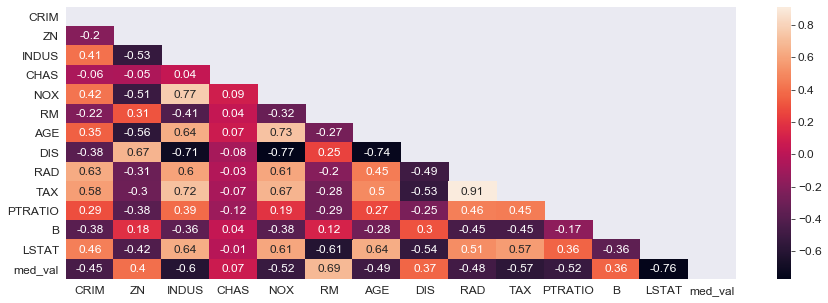

LSTAT     -0.76
INDUS     -0.60
TAX       -0.57
NOX       -0.52
PTRATIO   -0.52
AGE       -0.49
RAD       -0.48
CRIM      -0.45
CHAS       0.07
B          0.36
DIS        0.37
ZN         0.40
RM         0.69
med_val    1.00
Name: med_val, dtype: float64

In [8]:
corr = df.corr().round(2)

fig, ax = plt.subplots(figsize=(15,5))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, annot=True, mask=mask, ax=ax)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

#raise upper limit and lower lower limit to show top and bottom rows
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

#DIS is highly correlated with INDUS, NOX, AGE
#RAD and TAX are highly correlated
#Focus on features: LSTAT, PTRATIO, RM, ZN
corr['med_val'].sort_values()

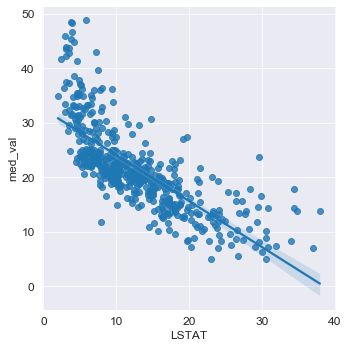

In [9]:
sns.lmplot(x='LSTAT', y='med_val',data =df);

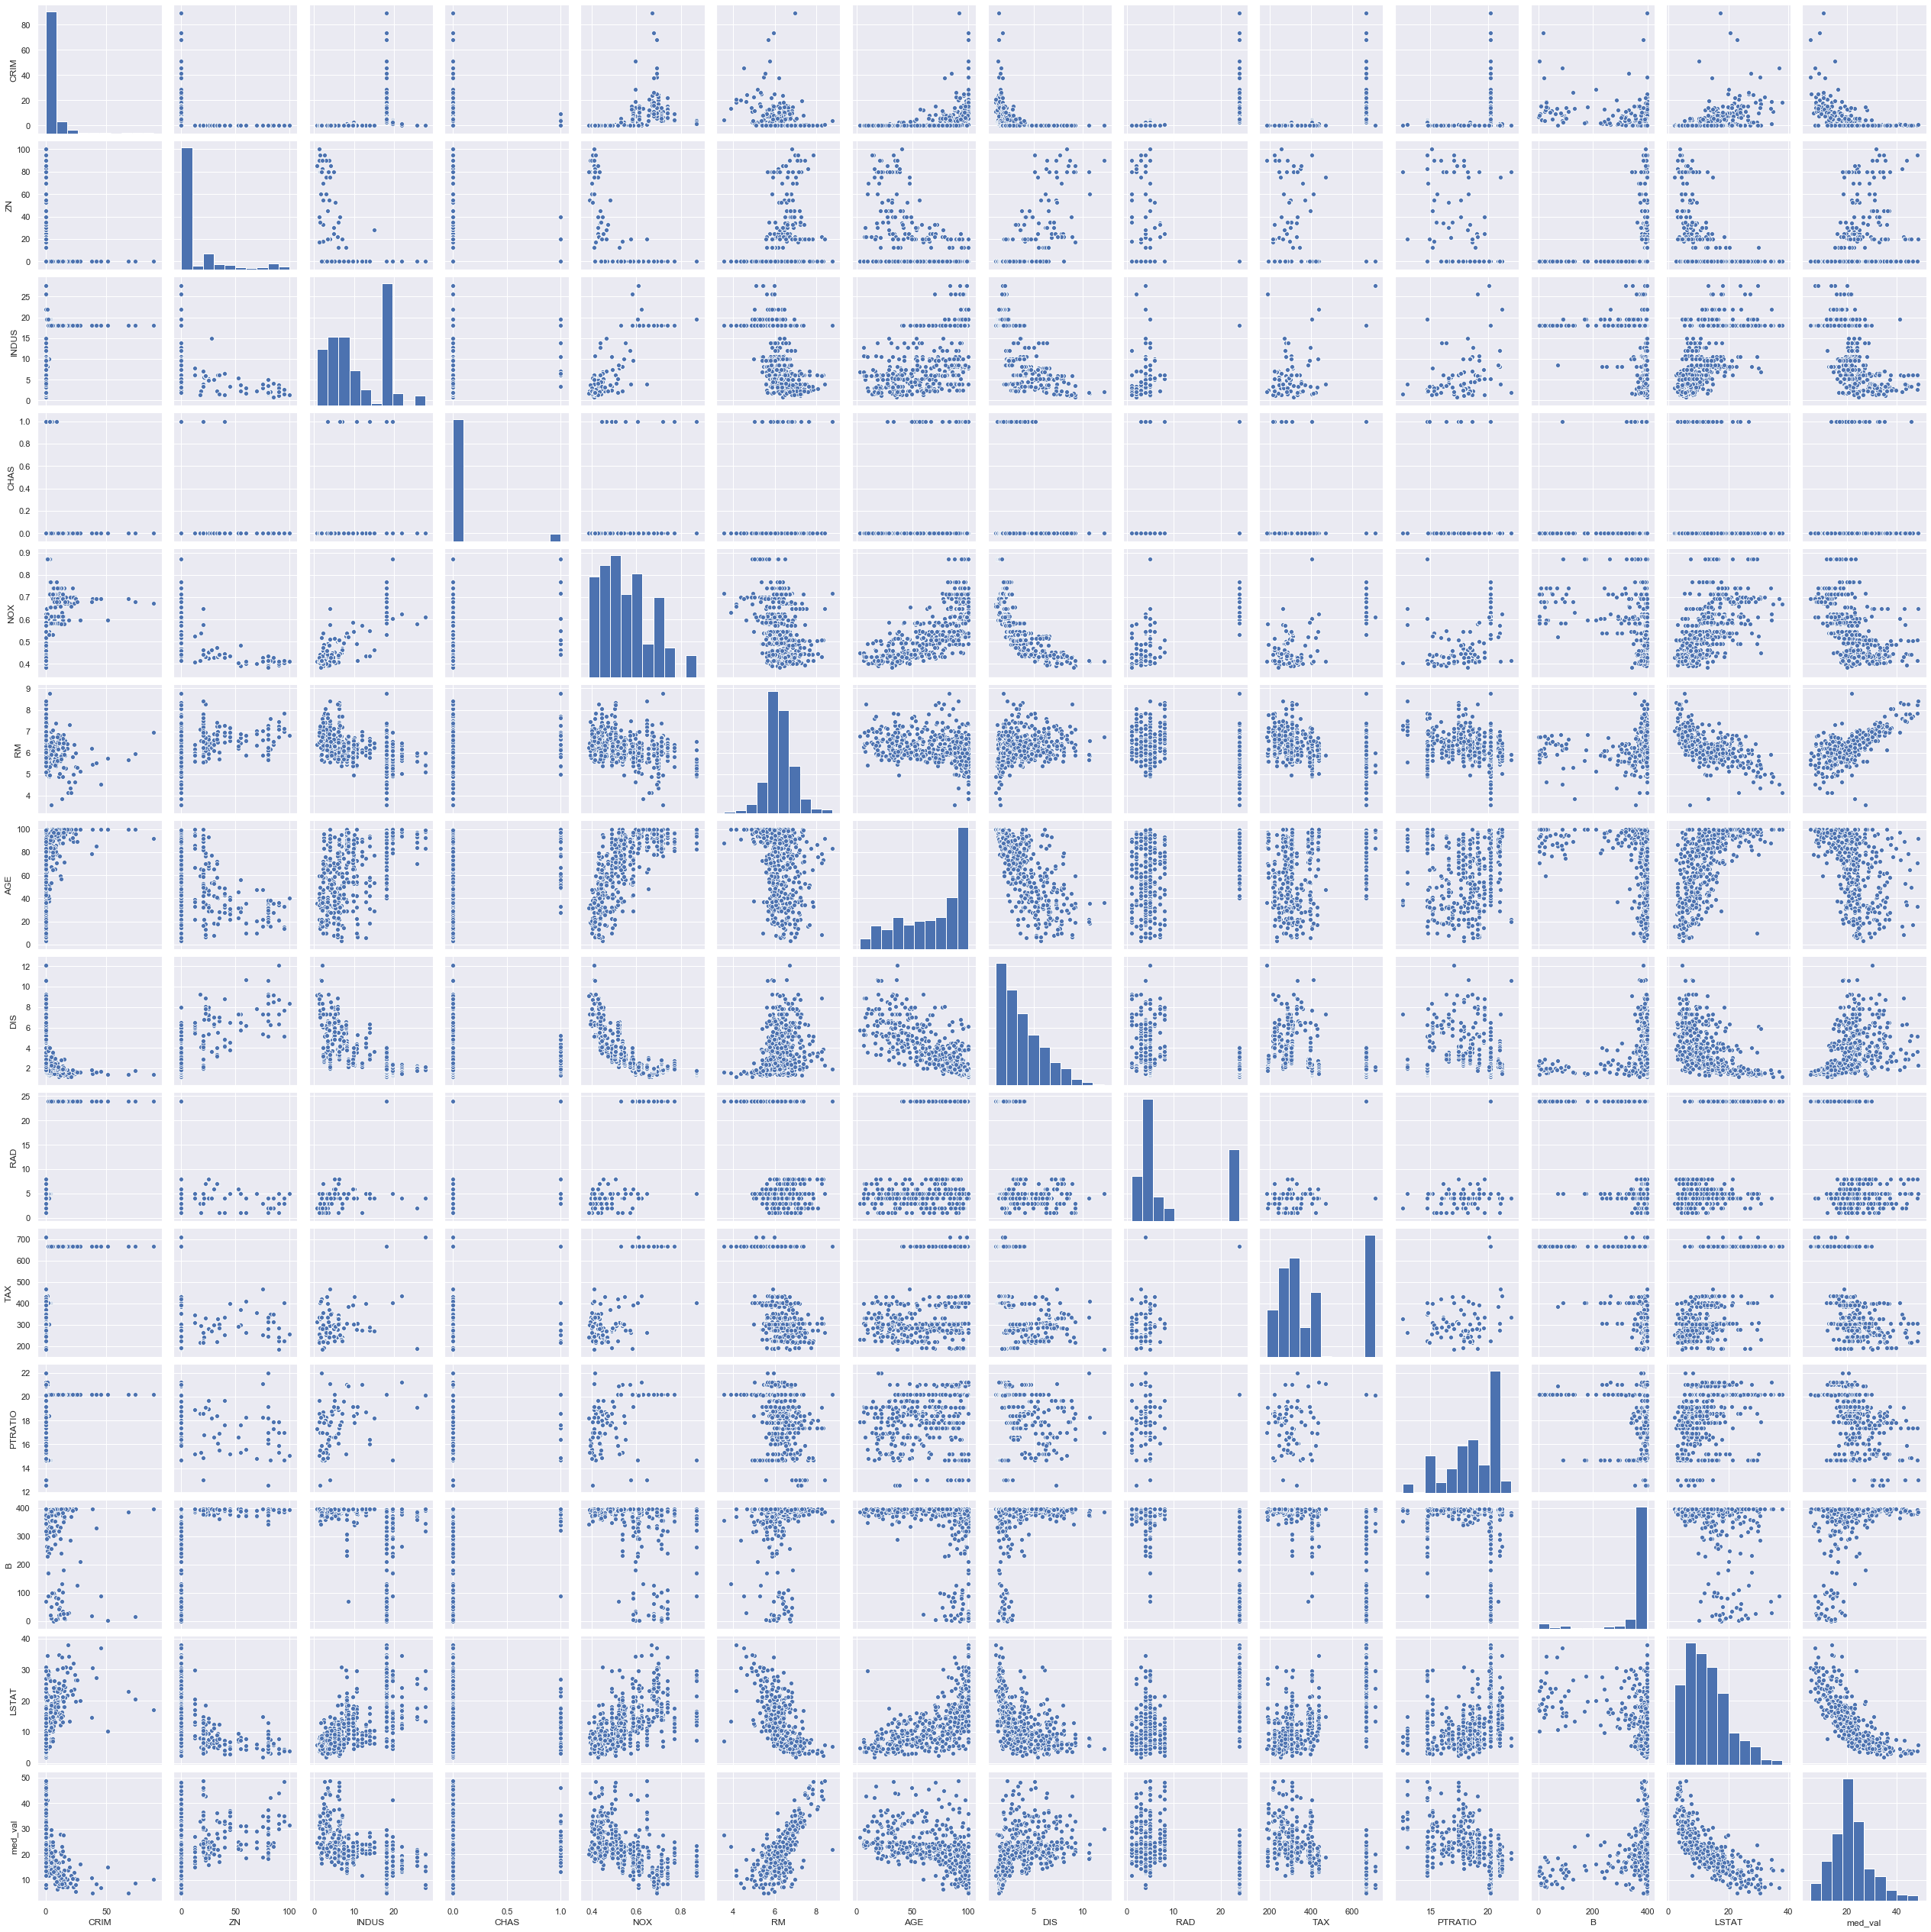

In [31]:
# RM close to a linear relationship
sns.pairplot(df);
#, x_vars = df.columns, y_vars = ['med_val']

# Modeling

## Test_train Split

In [41]:
#Maybe I shouldn't test_train split because of the size of dataset

# X = df[df.columns.drop(['med_val'])]
# y = df['med_val']

# X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = .2, random_state = 421)
# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)

(404, 4) (102, 4)
(404,) (102,)


## Baseline model with all features

In [35]:
X = df[df.columns.drop(['med_val'])]
y = df['med_val']

print(X.shape, y.shape)

#instantiate, fit, and predict baseline model
lr_mod = LinearRegression()
lr_mod.fit(X, y)
lr_preds = lr_mod.predict(X)

#baseline accuracy score .741
#after removing med_val = 50, baseline score .778
lr_mod.score(X,y)

(490, 13) (490,)


0.7776594795880641

In [15]:
#Baseline using statsmodels OLS
#Age and INDUS are not statistically significant at 5% confidence
X = df[df.columns.drop(['med_val'])]
y = df['med_val']

X_constant = sm.add_constant(X)
basemod = sm.OLS(y,X_constant).fit()
print(basemod.summary())

X:\Users\AC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     128.1
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          4.33e-146
Time:                        10:45:03   Log-Likelihood:                -1337.0
No. Observations:                 490   AIC:                             2702.
Df Residuals:                     476   BIC:                             2761.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2298      4.124      7.816      0.0

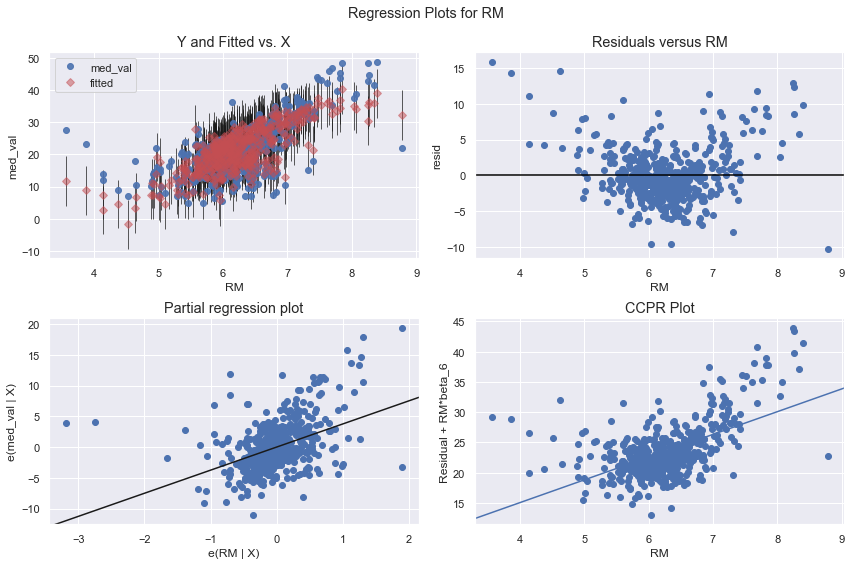

In [16]:
#residuals for RM are not random, closer to 0 around 5-7 RMs
#residuals indicate that there are systematic errors around higher and lower RM count
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(basemod, 'RM', fig=fig)

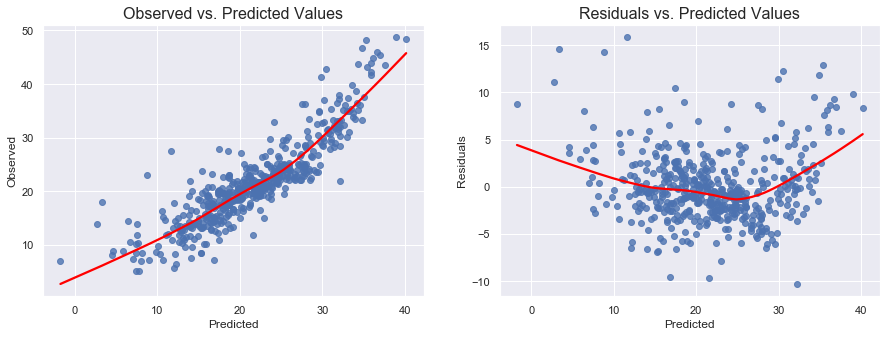

In [17]:
#linear assumption not satisfied
#points are not symmetrically distributed around the lines
lin_reg_tests.linearity_test(basemod, y)

## Linear Regression with Features Selected by Correlation

In [45]:
#Focus on features: LSTAT, PTRATIO, RM, ZN
#Selected features explain .713 of med_vals
#ZN not significant at 5% confidence interval, try another variable
#Tax triggers multicollinearity issues, even though only -0.57 correlation with LSTAT
X = df[['TAX','RM','LSTAT','PTRATIO']]
y = df['med_val']
X_constant = sm.add_constant(X)
print(X.shape, y.shape)

coorelation_mod = sm.OLS(y,X_constant).fit()
print(coorelation_mod.summary())

(490, 4) (490,)
                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     326.3
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          5.07e-136
Time:                        14:21:41   Log-Likelihood:                -1385.4
No. Observations:                 490   AIC:                             2781.
Df Residuals:                     485   BIC:                             2802.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3020      3.212    

In [46]:
#Focus on features: LSTAT, PTRATIO, RM, INDUS
#ZN not significant at 5% confidence interval, try another variable
#Tax triggers some condition number issue, even though only -0.57 correlation with LSTAT
    #vif also not revealing any multicollinearity issue
    #could be a scale issue
#Selected features explain .721 of med_vals
#even though LSTAT and INDUS are .6 correlated, no issues with multicollinearity
X = df[['INDUS','RM','LSTAT','PTRATIO']]
y = df['med_val']
X_constant = sm.add_constant(X)
print(X.shape, y.shape)

coorelation_mod2 = sm.OLS(y,X_constant).fit()
print(coorelation_mod2.summary())

(490, 4) (490,)
                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     313.0
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          7.86e-133
Time:                        14:21:42   Log-Likelihood:                -1392.8
No. Observations:                 490   AIC:                             2796.
Df Residuals:                     485   BIC:                             2817.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.7718      3.211    

In [47]:
#There doesn't seem to be a multicollinearity issue with Tax or INDUS
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,INDUS,RM,LSTAT,PTRATIO
vif,1.768694,1.610688,2.245515,1.217359


## Linear Regression after Scaling/Normalizing Selected Features

In [95]:
#need to normalize CRIM, ZN, INDUS, NOX, AGE, DIS, RAD, TAX, B
#scale LSTAT
#RM and med_val both gaussian distributions
df_scale = df[['LSTAT','PTRATIO','RM','TAX','med_val']].copy()

scaler = MinMaxScaler()
scaler.fit(df_scale)
test_scaled = scaler.transform(df_scale)
df_minmaxscale = pd.DataFrame(test_scaled, columns = df_scale.columns)

scaler2 = StandardScaler()
scaler2.fit(df_scale)
test_scaled2 = scaler2.transform(df_scale)
df_standardscale = pd.DataFrame(test_scaled2, columns = df_scale.columns)

In [93]:
# MinMaxScaler doesnt impact R-squared, but removes condition number issue
X = df_minmaxscale[['TAX','RM','LSTAT','PTRATIO']]
y = df_minmaxscale['med_val']
X_constant = sm.add_constant(X)
print(X.shape, y.shape)

df_minmaxscale_mod = sm.OLS(y,X_constant).fit()
print(df_minmaxscale_mod.summary())

(490, 4) (490,)
                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     326.3
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          5.07e-136
Time:                        15:52:42   Log-Likelihood:                 466.61
No. Observations:                 490   AIC:                            -923.2
Df Residuals:                     485   BIC:                            -902.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3714      0.031    

X:\Users\AC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [96]:
# standardscaler doesnt impact R-squared
# reduces condition number further than minmaxscaler
#AIC, BIC, and Log-Likelihood reversed signs from minmaxscaler
X = df_standardscale[['TAX','RM','LSTAT','PTRATIO']]
y = df_standardscale['med_val']
X_constant = sm.add_constant(X)
print(X.shape, y.shape)

df_standardscale_mod = sm.OLS(y,X_constant).fit()
print(df_standardscale_mod.summary())

(490, 4) (490,)
                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     326.3
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          5.07e-136
Time:                        15:54:57   Log-Likelihood:                -375.31
No. Observations:                 490   AIC:                             760.6
Df Residuals:                     485   BIC:                             781.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0      0.024    

X:\Users\AC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


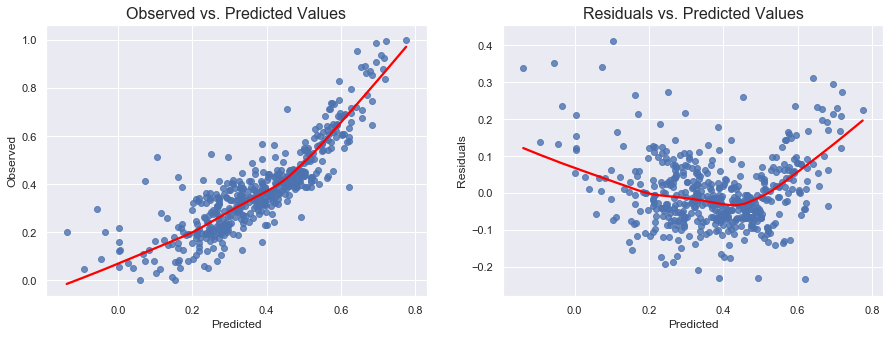

In [91]:
#linear assumption not satisfied
#same as basemod since the independent variables haven't been transformed
lin_reg_tests.linearity_test(df_scale_mod, y)

## Transforming Features Selected by Correlation

In [ ]:
df_scale

# Linear Regression after removing TAX > 600

In [84]:
test = df.copy()
print(test.shape)
test = test.loc[test['TAX']<600]
test = test[['TAX','RM','LSTAT','PTRATIO','med_val']]
print(test.shape)

scaler = MinMaxScaler()
scaler.fit(test)
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns = test.columns)

(490, 14)
(358, 5)


In [82]:
#removing the upper outliers from Tax improved R-squared to 0.808
#scaling with MinMaxScaler didn't improve R-squared, but fixed condition number issues
#probably overfitting by removing the high TAX values
X = test_scaled[['TAX','RM','LSTAT','PTRATIO']]
y = test_scaled['med_val']
X_constant = sm.add_constant(X)
print(X.shape, y.shape)

test_scale_mod = sm.OLS(y,X_constant).fit()
print(test_scale_mod.summary())

(358, 4) (358,)
                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     371.3
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          4.68e-125
Time:                        15:11:57   Log-Likelihood:                 374.39
No. Observations:                 358   AIC:                            -738.8
Df Residuals:                     353   BIC:                            -719.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1915      0.029    

## Linear Regression with Feature Selected by Addressing Multicollinearity

In [85]:
#after removing TAX, the vif are all under 5
#after removing ['TAX', 'NOX', 'DIS', 'LSTAT', 'RAD', 'INDUS'], the remaining vif are all under 2
#try a reduced model by removing these features

X = df[df.columns.drop(['med_val'])]
y = df['med_val']
X_constant = sm.add_constant(X)

collinear_var = []

for attempt in range(0,len(X_constant.columns)-1):
    vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
    collinear_var.append(pd.DataFrame({'vif': vif[1:]}, index=X_constant.columns[1:]).T.idxmax(axis=1)[0])
    print(pd.DataFrame({'vif': vif[1:]}, index=X_constant.columns[1:]).T)
    print(collinear_var)
    X_constant = X_constant[X_constant.columns.drop([collinear_var[-1]])]

         CRIM        ZN     INDUS      CHAS      NOX        RM       AGE  \
vif  1.792192  2.298758  3.991596  1.073995  4.39372  1.933744  3.100826   

          DIS       RAD       TAX   PTRATIO         B     LSTAT  
vif  3.955945  7.484496  9.008554  1.799084  1.348521  2.941491  
['TAX']
        CRIM       ZN     INDUS     CHAS       NOX        RM       AGE  \
vif  1.79194  2.18424  3.226015  1.05822  4.369271  1.923075  3.098044   

          DIS       RAD   PTRATIO         B   LSTAT  
vif  3.954446  2.837494  1.788839  1.347564  2.9408  
['TAX', 'NOX']
         CRIM        ZN     INDUS      CHAS        RM      AGE       DIS  \
vif  1.785343  2.183394  2.872809  1.057571  1.904013  2.87513  3.641492   

          RAD   PTRATIO         B     LSTAT  
vif  2.533616  1.598944  1.339554  2.927273  
['TAX', 'NOX', 'DIS']
         CRIM        ZN    INDUS     CHAS        RM       AGE       RAD  \
vif  1.765881  1.758636  2.51752  1.05684  1.879925  2.423551  2.507024   

      PTRATIO    

In [91]:
#after removing 'TAX' R-squared dropped a bit
#INDUS and AGE still not signifcantly affecting dependent variable, so remove
#removing INDUS and AGE doesn't strongly affect the Rsquared, as expected
X = df[df.columns.drop(['med_val','TAX','INDUS','AGE'])]
y = df['med_val']
X_constant = sm.add_constant(X)

mod2 = sm.OLS(y,X_constant).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     113.9
Date:                Wed, 09 Sep 2020   Prob (F-statistic):          1.21e-133
Time:                        11:28:07   Log-Likelihood:                -1504.3
No. Observations:                 506   AIC:                             3035.
Df Residuals:                     493   BIC:                             3089.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.6286      5.123      6.760      0.0

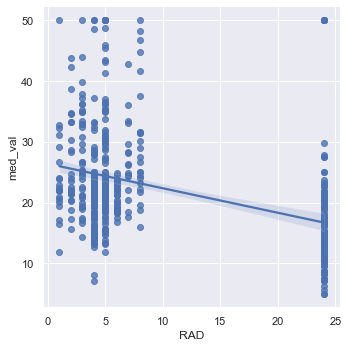

In [109]:
#DIS and RAD have coefficients that are the opposite of the relationship with med_val
#these two may be part of the multicollinearity issue
sns.lmplot(x='RAD', y='med_val', data = df[df.columns.drop(['TAX','INDUS','AGE'])]);

In [112]:
#removing DIS and RAD signifcantly reduces R-squared (~4%)
#causes other coefficients to fall out of the 95% confidence interval
#Increases Omnibus, Skew, kurtosis, Jarque-Bera
#Decreases Durbin Watson, Rsquared, Prob of JB, condition no.
#keeping DIS and removing RAD affects r_squared much less signifcantly
#this makes sense given the higher t value for DIS
X = df[df.columns.drop(['med_val','TAX','INDUS','AGE','RAD'])]
y = df['med_val']
X_constant = sm.add_constant(X)

mod3 = sm.OLS(y,X_constant).fit()
print(mod3.summary())

                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     148.1
Date:                Wed, 09 Sep 2020   Prob (F-statistic):          1.98e-134
Time:                        13:25:08   Log-Likelihood:                -1510.1
No. Observations:                 506   AIC:                             3040.
Df Residuals:                     496   BIC:                             3082.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.5080      4.873      6.056      0.0

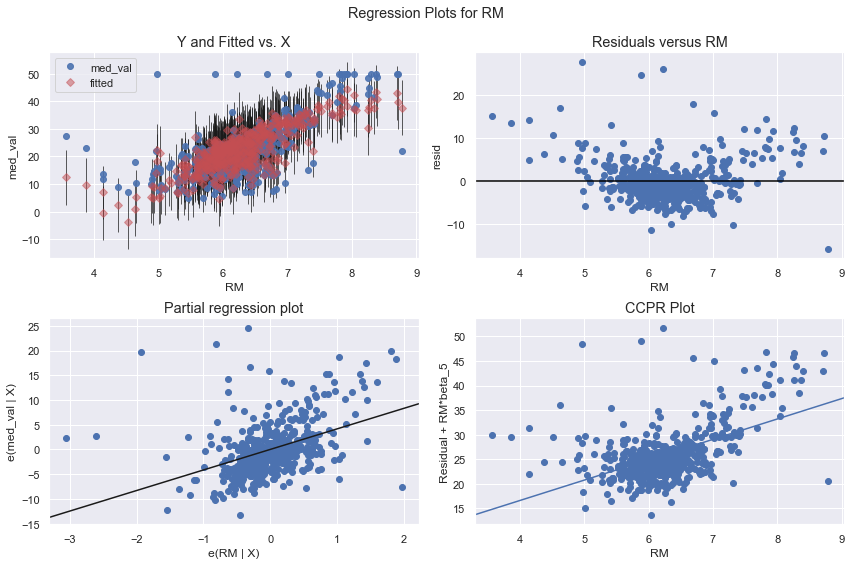

In [114]:
#residuals for RM are not random, closer to 0 around 5-7 RMs, slight U shape
#residuals indicate that there are systematic errors around higher and lower RM count
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(mod3, 'RM', fig=fig)

# Remove Outliers

In [ ]:
#what happens when I remove outliers from med_val
#model based on all independent variables can explain a little more R2 of .741 vs .762
#linearity improves, but still not perfect

In [ ]:
outliers_removed = df.copy()
print(outliers_removed.shape)

q1, q3 = np.percentile(outliers_removed['med_val'],[25,75])
lower = q1 - (1.5 * stats.iqr(outliers_removed['med_val']))
upper = q3 + (1.5 * stats.iqr(outliers_removed['med_val']))
print('med_val range: ',lower, '-->', upper)
outliers_removed = outliers_removed.loc[(df['med_val']>lower) & (outliers_removed['med_val']<upper)]
print(outliers_removed.shape)
outliers_removed.shape

In [32]:
df_scale = df.copy()
print(df_scale.shape)

#remove outliers from LSTAT
df_scale = df_scale.loc[df_scale['LSTAT'] <= 31.77]
#remove outliers from PTRATIO
df_scale = df_scale.loc[df_scale['PTRATIO'] >= 13.20]
#remove outliers from RM
df_scale = df_scale.loc[(df_scale['RM'] >= 4.84) & (df_scale['RM'] <= 7.62)]
#remove outliers from ZN
df_scale = df_scale.loc[df_scale['ZN'] <= 31.25]

df_scale.shape

(490, 14)


(390, 14)

In [ ]:
X = outliers_removed[outliers_removed.columns.drop(['med_val'])]
y = outliers_removed['med_val']

X_constant = sm.add_constant(X)
model = sm.OLS(y,X_constant).fit()
print(model.summary())

In [ ]:
#linear assumption not satisfied
#points are not symmetrically distributed around the lines
#systematically underpredicting
lin_reg_tests.linearity_test(model, y)

In [ ]:
model.resid.mean()

In [ ]:
#remove Tax, RAD (these two are highly correlated)
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

In [ ]:
#filter-based feature selection
#I'll use features: LSTAT, INDUS, RM, ZN, DIS

corr = outliers_removed.corr().round(2)
corr['med_val'].sort_values()

In [ ]:
#still get a high condition number
X = outliers_removed[outliers_removed.columns.drop(['RAD','TAX','med_val'])]
y = outliers_removed['med_val']

X_constant = sm.add_constant(X)
model = sm.OLS(y,X_constant).fit()
print(model.summary())

In [ ]:
#closer to linearity assumption, but not perfect
#still slightly skewed towards underpredicting, but better than before
lin_reg_tests.linearity_test(model, y)

## K-Fold Cross-Validation

In [67]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr_mod, X_train, y_train, cv=5)

array([0.737392  , 0.70088039, 0.51172559, 0.72255274, 0.7002127 ])

In [68]:
cv_df = pd.DataFrame()
def cv_scores(model, X, y, cv):
    for cv_count in range(5,cv+1):
        cv_df[cv_count] = pd.Series(cross_val_score(model, X, y, cv=cv_count)).describe()
    return cv_df

In [69]:
cv_scores(lr_mod, X_train, y_train, cv=10)
#seems like less k-folds leads to better scores, less overfitting

,5,6,7,8,9,10
count,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
mean,0.674553,0.676224,0.665786,0.672404,0.667110,0.680300
std,0.092354,0.123338,0.114894,0.120918,0.143305,0.129181
min,0.511726,0.437261,0.484579,0.427503,0.359893,0.404783
25%,0.700213,0.684974,0.597216,0.632447,0.640766,0.624875
50%,0.700880,0.708035,0.699295,0.692702,0.709847,0.687934
75%,0.722553,0.727000,0.741780,0.744225,0.763162,0.773627
max,0.737392,0.793406,0.798633,0.814161,0.823006,0.847863


## Modeling (KNN)

## RandomForrest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train , y_train)
y_pred = rf.predict(X_test)

plt.scatter(Y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices Vs Predicted prices: $Y_i$ Vs $\hat{Y}_i$")
plt.show()

In [ ]:
print(sklearn.metrics.mean_absolute_error(Y_test, y_pred))
print(np.sqrt(mse))

In [ ]:
print(rf.score(X_test , y_test))

In [ ]:
sns.distplot(y_pred)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

test_score = r2_score(y_test , y_pred)
spearman = spearmanr(y_test, y_pred)
pearson = pearsonr(y_test, y_pred)
print("Out of Bag R2 Score" , rf.oob_score_)
print("Test Data R2 Score:" , test_score)
print("Test Data Spearman Correlation:" ,  round(spearman[0], 3))
print("Test Data Pearson Correlation" , round(pearson[0],3))

### Challenge: Create a line plot of `ZN` and `INDUS` in the housing data. 

- For `ZN`, use a solid green line. For `INDUS`, use a blue dashed line.
- Change the figure size to a width of 12 and height of 8.
- Change the style sheet to something you find [here](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html).

In [ ]:
#ZN vs INDUS scatter plot
housing.plot(x='ZN', y='INDUS', kind='scatter', 
           color='dodgerblue', figsize=(15,7), s=100);

In [ ]:
# This list comprehension sets the point sizes ('s') to be the squares of the values in housing['DIS']
housing.plot(x='ZN', y='INDUS', kind='scatter', 
           color='dodgerblue', figsize=(15,7), s=[x**2 for x in housing['DIS']]);

# APPENDIX

In [19]:
#Pearson's correlation coefficient
from scikitlearn import f_regression()

SyntaxError: invalid syntax (<ipython-input-19-737dd5528ed4>, line 2)

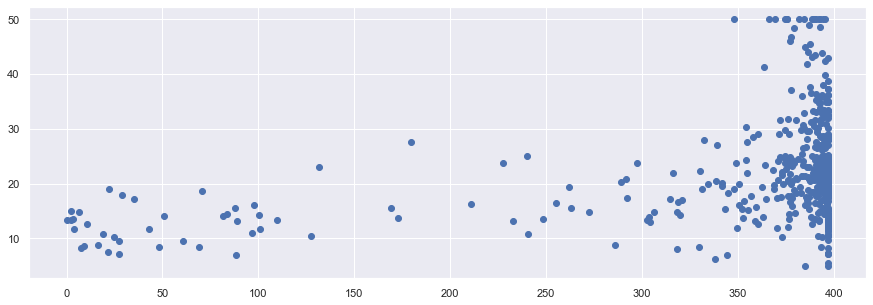

In [9]:
#lower lstat correlates with higher med_val
#higher RM correlates with higher med_val

a = df['B']
b = df['med_val']
plt.plot(a,b,'o')

{'whiskers': [<matplotlib.lines.Line2D at 0x144f98ee588>,
 'caps': [<matplotlib.lines.Line2D at 0x144f98eee48>,
 'boxes': [<matplotlib.lines.Line2D at 0x144f98e9a08>],
 'medians': [<matplotlib.lines.Line2D at 0x144f98f2dc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x144f98f6c48>],
 'means': []}

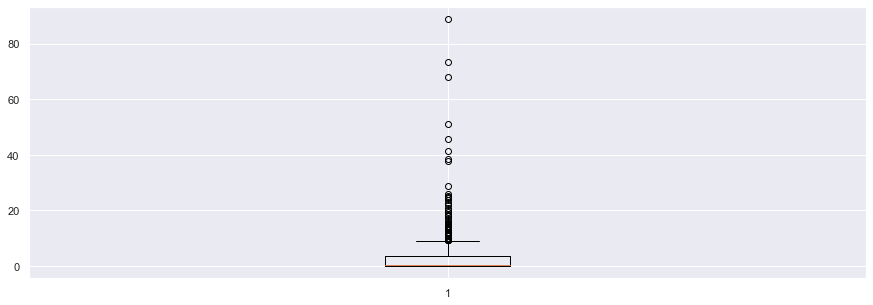

In [11]:
#any outliers? Maybe focus on just the variables that are highly correlated
plt.boxplot(df['CRIM'])

In [90]:
#residuals average about 0
basemod.resid.mean()

6.392778269857423e-15

In [20]:
#check for multicollinearity
#Tax, RAD, NOX, DIS, AGE, INDUS all higher vif, consider for removal
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
vif,1.792192,2.298758,3.991596,1.073995,4.39372,1.933744,3.100826,3.955945,7.484496,9.008554,1.799084,1.348521,2.941491



 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  6.512179e+01
p-value                        6.265431e-09
f-value                        5.590227e+00
f p-value                      1.495776e-09

 Goldfeld-Quandt test ----
                    value
F statistic  2.431147e+00
p-value      7.302072e-12

 Residuals plots ----


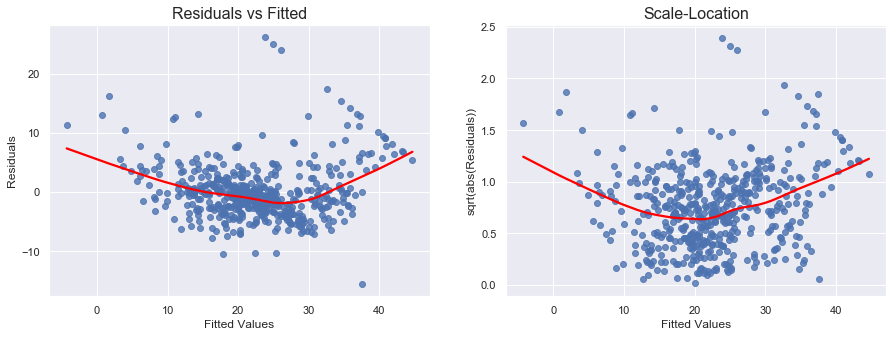

In [21]:
# The residuals are not random, there is a slight u-shape pattern
# reject the hypothesis of homoscedasticity
lin_reg_tests.homoscedasticity_test(mod)

1.0783751186797235


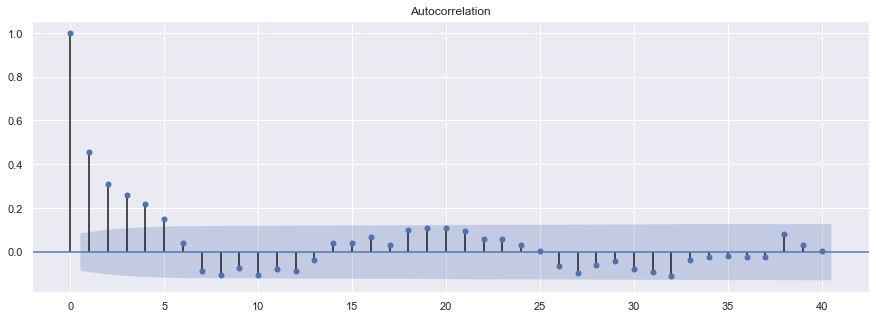

In [22]:
#Dubin-watson test for autocorrelation
# Durbin-watson value of 1.078, slight positive autocorrelation
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(mod.resid))
acf = smt.graphics.plot_acf(mod.resid, lags=40, alpha=0.05)

In [23]:
# cannot prove lack of correlation for any pair
for column in X.columns:
    corr_test = stats.pearsonr(X[column], mod.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.3f}, p-value: {corr_test[1]:.3f}')

Variable: CRIM --- correlation: -0.000, p-value: 1.000
Variable: ZN --- correlation: -0.000, p-value: 1.000
Variable: INDUS --- correlation: 0.000, p-value: 1.000
Variable: CHAS --- correlation: 0.000, p-value: 1.000
Variable: NOX --- correlation: 0.000, p-value: 1.000
Variable: RM --- correlation: 0.000, p-value: 1.000
Variable: AGE --- correlation: 0.000, p-value: 1.000
Variable: DIS --- correlation: -0.000, p-value: 1.000
Variable: RAD --- correlation: -0.000, p-value: 1.000
Variable: TAX --- correlation: -0.000, p-value: 1.000
Variable: PTRATIO --- correlation: 0.000, p-value: 1.000
Variable: B --- correlation: -0.000, p-value: 1.000
Variable: LSTAT --- correlation: 0.000, p-value: 1.000


In [24]:
#more observations than features
df.shape

(506, 14)

In [25]:
#There is some variance in each feature
#NOX and CHAS particularly low variance
X.apply(np.var, axis = 0)

CRIM          73.840360
ZN           542.861840
INDUS         46.971430
CHAS           0.064385
NOX            0.013401
RM             0.492695
AGE          790.792473
DIS            4.425252
RAD           75.666531
TAX        28348.623600
PTRATIO        4.677726
B           8318.280421
LSTAT         50.893979
dtype: float64

Jarque-Bera test ---- statistic: 783.1263, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9014, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.3329, p-value: 0.0000
Anderson-Darling test ---- statistic: 10.5207, 5% critical value: 0.7810
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


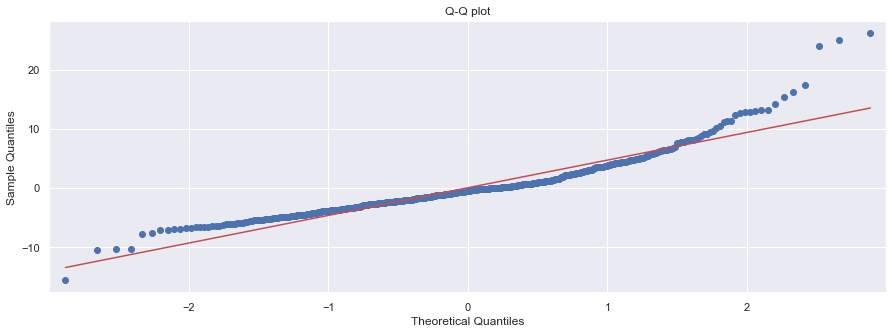

In [26]:
#the residuals do not follow a gaussian distribution
lin_reg_tests.normality_of_residuals_test(mod)